# Visualising Analysis Regions for our Samples

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 10
from xga.samples import ClusterSample
from xga.xspec import single_temp_apec
from xga.imagetools.misc import physical_rad_to_pix
from xga.exceptions import NoProductAvailableError
from xga import BLACKLIST
from xga.relations.clusters.MT import arnaud_m500, xxl_m500, xxl_cosmos_cccp_m500
from xga.relations.fit import scaling_relation_odr
from xga.models import power_law

## Defining useful functions

In [24]:
def analysis_regions_visualisation(src, save_path, view=False):
    rt = src.get_combined_ratemaps()
    src_msk, bck_msk = src.get_mask('r500')
    int_msk = src.get_interloper_mask()
    
    rpix = physical_rad_to_pix(rt, src.r500, src.default_coord, src.redshift, src.cosmo)
    src_ann = Quantity([0, rpix.value], 'pix')
    bck_ann = Quantity(rpix*src.background_radius_factors)
    rt.regions = src._interloper_regions
    
#     coords = Quantity([src.peak, src.ra_dec])
    coords = src.peak
    if view:
        rt.view(coords, int_msk, radial_bins_pix=src_ann.value, back_bin_pix=bck_ann.value, zoom_in=True, 
                view_regions=True)
    else:
        rt.save_view(save_path, coords, int_msk, radial_bins_pix=src_ann.value, back_bin_pix=bck_ann.value, 
                     zoom_in=True, view_regions=True)
    plt.close('all')

## Setting up cosmology

Though three of the previous analyses use the same concordance cosmology, the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define four separate cosmology objects to pass into our samples.

In [3]:
xcs_cosmo = LambdaCDM(70, 0.3, 0.7)
xxl_cosmo = WMAP9
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### SDSSRM-XCS Volume Limited

This is the recent SDSSRM-XCS sample. The temperatures and luminosities are measured by the XCS luminosity-temperature pipeline, and with this we demonstrate that XGA temperatures and luminosities are consistent with existing XCS results.

In order to achieve maximum consistency, we use the XAPA coordinates as the central position for spectrum generation (turning off the XGA peak finder with `use_peak=False`). We have also made sure to use the same cosmology.

In [4]:
xcs3p = pd.read_csv("sample_files/xcs3p_sdssrm_vol_lim_temperr_25%_clusters.csv")

In [5]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values
dec = xcs3p['xapa_dec'].values
z = xcs3p['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values
# In arcminutes, ClusterSample declaration will convert to kpc using the provided cosmology
r500 = Quantity(xcs3p['r500'].values, 'arcmin')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values
r_err = xcs3p['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
xcs_srcs = ClusterSample(ra, dec, z, n, r500=r500, richness=r, richness_err=r_err, cosmology=xcs_cosmo, 
                         load_fits=True, use_peak=True, clean_obs=True, clean_obs_reg='r500', 
                         clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   6%|██▊                                         | 10/157 [00:10<02:30,  1.02s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-11331 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   8%|███▎                                        | 12/157 [00:12<02:38,  1.09s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-28849 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   8%|███▋                               

Setting up Galaxy Clusters:  20%|████████▉                                   | 32/157 [01:59<14:17,  6.86s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-6955 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  21%|█████████▏                                  | 33/157 [02:03<12:20,  5.97s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-64824 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  22%|█████████▌                          

Setting up Galaxy Clusters:  51%|██████████████████████▍                     | 80/157 [04:30<04:29,  3.50s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-58896 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:164: UserWarning: After applying the criteria for the minimum amount of cluster required on an observation, SDSSXCS-58896 cannot be declared as all potential observations were removed
  warn("After applying the criteria for the minimum amount of cluster required on an "
Setting up Galaxy Clusters:  52%|██████████████████████▉                     | 82/157 [05:11<13:08, 10.52s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/x

Setting up Galaxy Clusters:  82%|███████████████████████████████████▎       | 129/157 [08:30<00:36,  1.30s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-575 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  83%|███████████████████████████████████▌       | 130/157 [08:32<00:40,  1.51s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-2 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  83%|███████████████████████████████████▉     

### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [6]:
xxlgc100 = pd.read_csv("sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [7]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=True, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:08<13:33,  8.30s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                            

Setting up Galaxy Clusters:  16%|███████▎                                     | 16/99 [02:11<09:14,  6.68s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-111 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [02:21<10:27,  7.65s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                   

Setting up Galaxy Clusters:  30%|█████████████▋                               | 30/99 [05:24<23:23, 20.34s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-62 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:149: UserWarning: The peak finding algorithm has not converged for XLSSC-62, using user supplied coordinates
  warn("The peak finding algorithm has not converged for {}, using user "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-62 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("

Setting up Galaxy Clusters:  39%|█████████████████▋                           | 39/99 [08:34<20:57, 20.95s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-10 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  40%|██████████████████▏                          | 40/99 [08:44<17:24, 17.70s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-103 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  41%|██████████████████▋                         

Setting up Galaxy Clusters:  55%|████████████████████████▌                    | 54/99 [11:30<05:57,  7.95s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-513 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  56%|█████████████████████████                    | 55/99 [11:38<05:49,  7.95s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-525 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  57%|█████████████████████████▍                 

Setting up Galaxy Clusters:  70%|███████████████████████████████▎             | 69/99 [12:59<03:35,  7.20s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0677820144, associated with source XLSSC-515
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0505383201, associated with source XLSSC-515
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-515 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files

Setting up Galaxy Clusters:  82%|████████████████████████████████████▊        | 81/99 [14:12<01:47,  5.95s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-532 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  83%|█████████████████████████████████████▎       | 82/99 [14:18<01:40,  5.90s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-519 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  84%|█████████████████████████████████████▋     

Setting up Galaxy Clusters:  97%|███████████████████████████████████████████▋ | 96/99 [15:56<00:23,  7.78s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-509 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  98%|████████████████████████████████████████████ | 97/99 [16:04<00:15,  7.77s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: XLSSC-510 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  99%|███████████████████████████████████████████

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [8]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [9]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=True, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [03:46<06:54, 12.94s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [04:52<06:45, 15.01s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  90%|███████████████████████████████████████▌    | 45/50 [10:11<01:18, 15.72s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: Us

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  89%|████████████████████████████████████████     | 41/46 [07:25<01:24, 16.88s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0093031601, associated with source Abell2261
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: Abell2261 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn(

### Planck Selected with XMM follow-up

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [10]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [11]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['planck_ra'].values
dec = lovisari['planck_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=True, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|█████████████████████▌                     | 60/120 [13:29<10:32, 10.55s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|█████████████████████▊                     | 61/120 [13:49<13:05, 13.32s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.8

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/x

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050101/0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_

Setting up Galaxy Clusters:  22%|█████████▌                                  | 26/120 [06:01<19:13, 12.27s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G072.63+41.46 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: G072.63+41.46 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G072.63+41.46 was not successful, or no matching sp

Setting up Galaxy Clusters:  42%|██████████████████▋                         | 51/120 [10:06<11:17,  9.82s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G171.94-40.65 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  44%|███████████████████▍                        | 53/120 [10:25<11:21, 10.17s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G182.44-28.29 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning:

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/its/home/dt237/.conda/envs/xga

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0112230501/0112230501_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Setting up Galaxy Clusters:  52%|███████████████████████                     | 63/120 [12:37<15:10, 15.98s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G228.49+53.12 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G252.96-56.05 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0603050201 and is very close to the user supplied coordinates of G252.96-56.05. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/extended.py:225: UserWarning: A PSF sized extended source has been detected in 0603050101 and is very close to the user supplied coordinates of G252.96-56.05. It will not be e

Setting up Galaxy Clusters:  95%|████████████████████████████████████████▊  | 114/120 [20:51<01:09, 11.65s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0720250301 and is very close to the user supplied coordinates of G335.59-46.46. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
Setting up Galaxy Clusters: 100%|███████████████████████████████████████████| 120/120 [21:31<00:00, 10.77s/it]


## Visualising $R_{500}$ and $R^{\rm{background}}_{500}$ regions

Here we generate combined ratemaps for all the clusters in the samples, overlaying the $R_{500}$ analysis region (as a solid circle), the background annulus (enclosed by two dashed circles) which by default goes from [1.05-1.5]$R_{500}$, the X-ray peak coordinate measured by XGA (the solid white crosshair), and the original literature coordinate (the dashed white crosshair).

We also mask the regions that XGA has defined as contaminants, and overlay their XCS region. Due to the large number of clusters in our various samples, we only display one cluster per sample here (as an example), and save all visualisations to the `cluster_visualisations/{sample name}` directories:

In [12]:
if not os.path.exists('cluster_visualisations/sdssrm-xcs'):
    os.makedirs('cluster_visualisations/sdssrm-xcs')

if not os.path.exists('cluster_visualisations/xxl'):
    os.makedirs('cluster_visualisations/xxl')
    
if not os.path.exists('cluster_visualisations/locuss'):
    os.makedirs('cluster_visualisations/locuss')

if not os.path.exists('cluster_visualisations/lovisari'):
    os.makedirs('cluster_visualisations/lovisari')

### SDSSRM-XCS Volume Limited

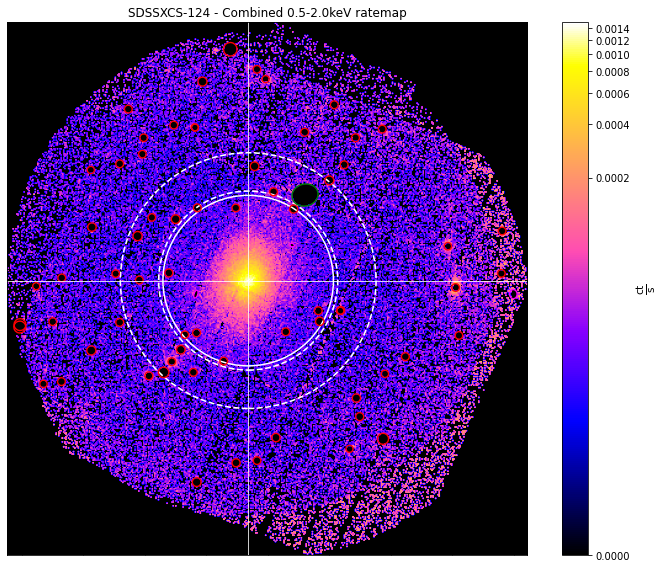

In [25]:
analysis_regions_visualisation(xcs_srcs[0], 'cluster_visualisations/sdssrm-xcs/{}.png'.format(xcs_srcs[0].name), 
                               view=True)
for src in xcs_srcs:
    analysis_regions_visualisation(src, 'cluster_visualisations/sdssrm-xcs/{}.png'.format(src.name))

### XXL-100-GC

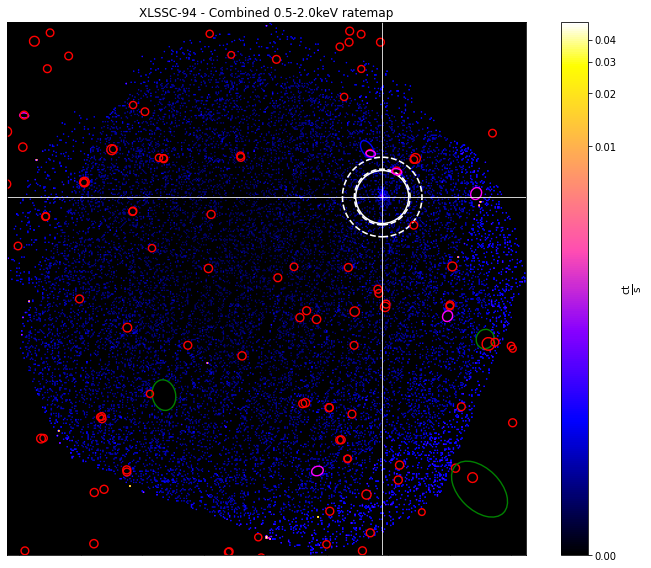

In [26]:
analysis_regions_visualisation(xxl_srcs[0], 'cluster_visualisations/xxl/{}.png'.format(xcs_srcs[0].name), 
                               view=True)
for src in xxl_srcs:
    analysis_regions_visualisation(src, 'cluster_visualisations/xxl/{}.png'.format(src.name))

### LoCuSS High-$L_{\rm{X}}$

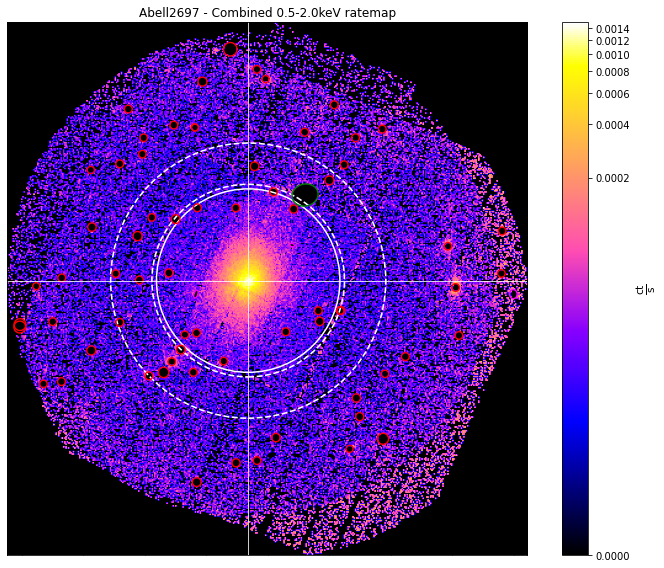

In [27]:
analysis_regions_visualisation(locuss_srcs[0], 'cluster_visualisations/locuss/{}.png'.format(xcs_srcs[0].name), 
                               view=True)
for src in locuss_srcs:
    analysis_regions_visualisation(src, 'cluster_visualisations/locuss/{}.png'.format(src.name))

### Lovisari et al.

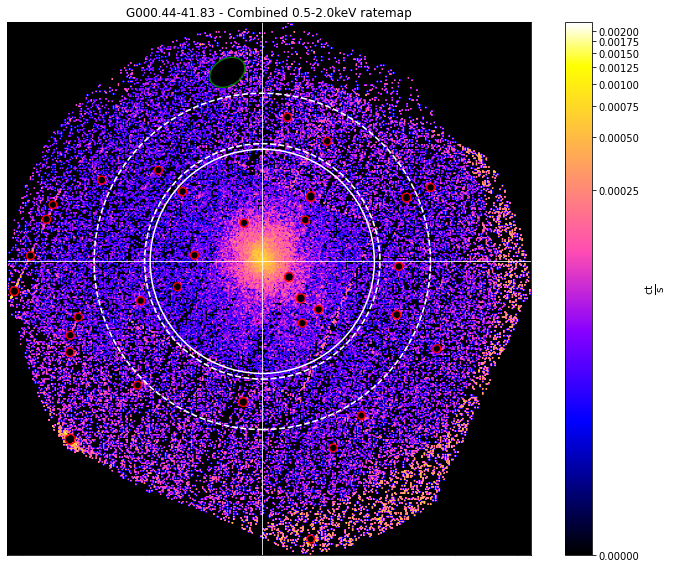

In [28]:
analysis_regions_visualisation(lovisari_srcs[0], 'cluster_visualisations/lovisari/{}.png'.format(xcs_srcs[0].name), 
                               view=True)
for src in lovisari_srcs:
    analysis_regions_visualisation(src, 'cluster_visualisations/lovisari/{}.png'.format(src.name))

## Specific Strange Cases

### LoCuSS High-$L_{\rm{X}}$

0093030801


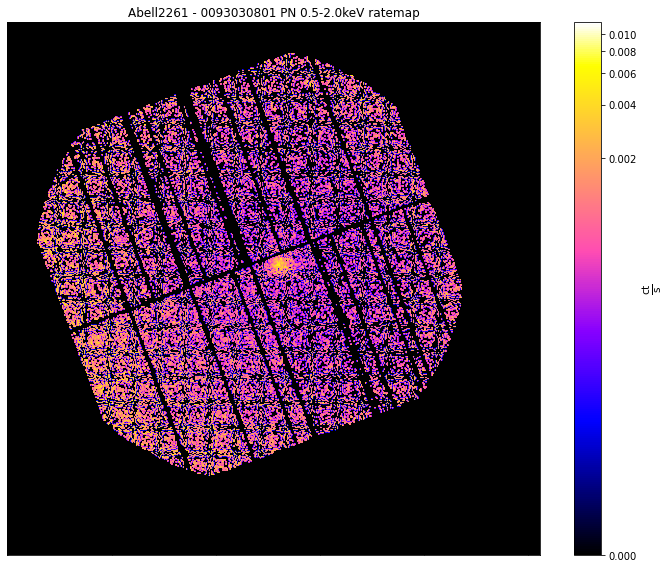

0093030301


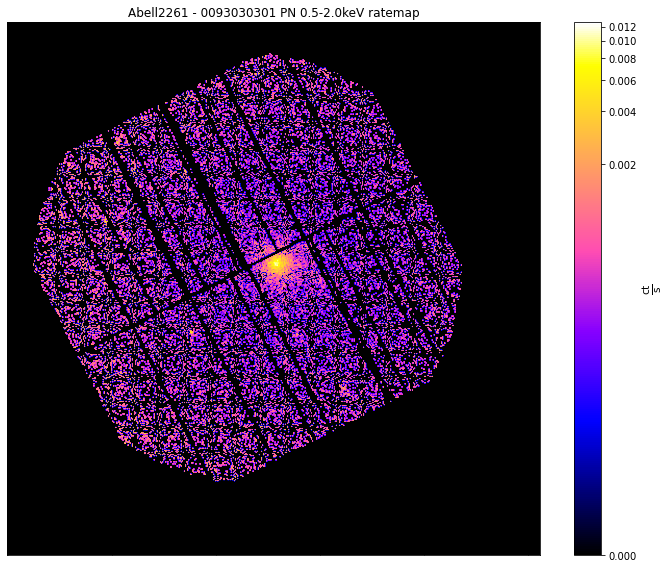

0093031601


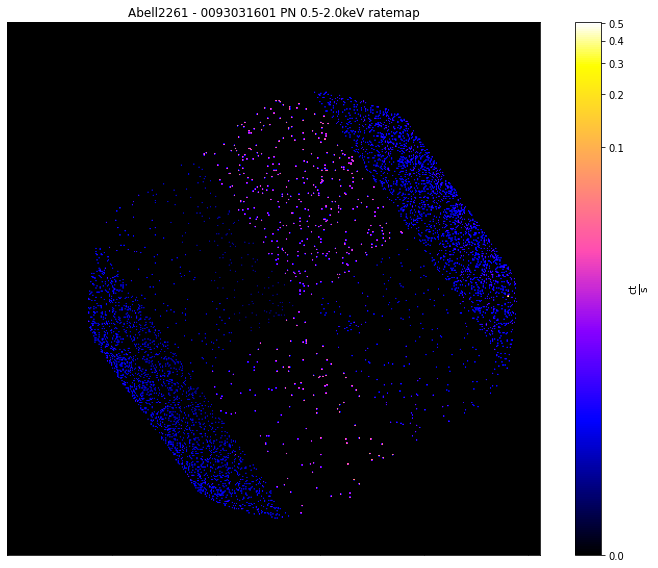

0693180901


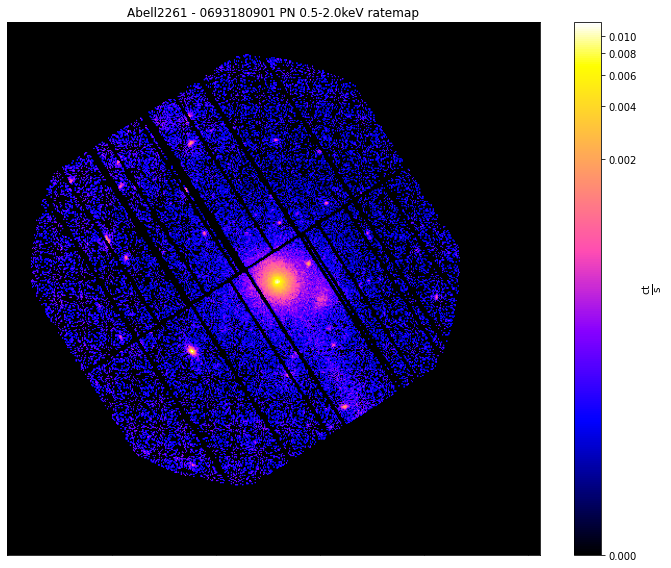


-----------------------------------------------------
Source Name - Abell2261
User Coordinates - (260.613, 32.1323) degrees
X-ray Peak - (260.61399359916896, 32.13176502614942) degrees
nH - 0.0333 1e+22 / cm2
Redshift - 0.224
XMM ObsIDs - 4
PN Observations - 4
MOS1 Observations - 4
MOS2 Observations - 4
On-Axis - 4
With regions - 4
Total regions - 84
Obs with 1 detection - 4
Obs with >1 matches - 0
Images associated - 36
Exposure maps associated - 24
Combined Ratemaps associated - 2
Spectra associated - 84
Fitted Models - constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec
R500 - 1220.0 kpc
R500 SNR - 294.13
R2500 - 580.0 kpc
R2500 SNR - 287.1
R500 Tx - 7.38±0.1[keV]
R500 0.5-2.0keV Lx - 6.96±0.16[e+44 erg/s]
-----------------------------------------------------



In [17]:
src = locuss_srcs['Abell2261']
for rt in src.get_ratemaps(inst='pn', lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV')):
    print(rt.obs_id)
    rt.view()
src.info()